# Sequence Model for Primer Design
* Reference
    * [기초부터 시작하는 NLP: SEQUENCE TO SEQUENCE 네트워크와 ATTENTION을 이용한 번역](https://tutorials.pytorch.kr/intermediate/seq2seq_translation_tutorial.html)
    * [딥 러닝을 이용한 자연어처리 입문 - 1) 시퀀스-투-시퀀스(Sequence-to-Sequence, seq2seq)](https://wikidocs.net/24996)
* TODO
    * cuda
    * attention decoder

In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
import pandas as pd
import xlrd
import numpy as np
import os

In [52]:
from __future__ import unicode_literals, print_function, division
# from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [53]:
import json
import os

In [54]:
from model import *
from run import *

In [55]:
device = torch.device('cpu')
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Import Data

In [56]:
file_path = './data'
file_name = '연중과제 streptococcus pyogenes primer design 210216.xlsx'

In [57]:
data_excel = pd.read_excel(os.path.join(file_path, file_name)
                        , header = 2  # 2번째 행을 헤더로 사용
                          )

In [ ]:
data_excel.head()

In [59]:
data_excel.keys()

Index(['Total #', '#', 'primer', 'sequence', 'location', 'Length', 'Tm', 'GC%',
       'product size', 'product  sequence', 'ct', 'RFU', 'ct.1', 'RFU.1',
       'ct.2', 'RFU.2', 'gene', 'gene 전체 서열', '나온 개수', 'Unnamed: 19',
       'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23',
       'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26'],
      dtype='object')

'#': id   
product sequence : 분석에 사용할 sequence

In [60]:
prod_seq = data_excel[['#', 'product  sequence']]

In [ ]:
prod_seq

In [62]:
prod_seq = prod_seq.dropna(axis=0)

In [63]:
prod_seq = prod_seq.astype({'#':'int32'})

In [ ]:
prod_seq

In [65]:
prod_seq = prod_seq.set_index('#', drop=True)  # COLUMN NAME 통일

In [ ]:
prod_seq_col = prod_seq['product  sequence']
prod_seq_col

In [67]:
# Max Length 계산하기
MAX_SEQ_LEN = max(prod_seq_col.apply(lambda x:len(x)))
MAX_SEQ_LEN

198

In [68]:
# Min Length 계산하기
min(prod_seq_col.apply(lambda x:len(x)))

86

In [69]:
fake_data = []

In [70]:
import random
random.randint(0,4)

3

In [71]:
bps = ['A','T','G','C']
bp = 'ATGC' * 100
fake_data = []
start = 0
end = 80

for i in range(50):
    sPos = random.randint(start, start+10)
    ePos = random.randint(end, end+30)
    fake_data += [bp[sPos:ePos]]
#     now = random.randint(start, end)
#     fake_data += [bp[now:now+20]]

## Integer and One-hot encoding

In [72]:
SOS_token = 1  # 0은 패딩
EOS_token = 2

class DictDNA:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}  
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.base_key = 3  # SOS 와 EOS 포함

    def add_sequence(self, sequence):
        # TODO k-mer
        # word = base
        for base in sequence:
            self.add_base(base)

    def add_base(self, base):
        # SOS 넣기
        if base not in self.word2index:
            self.word2index[base] = self.base_key
            self.word2count[base] = 1
            self.index2word[self.base_key] = base
            self.base_key += 1
        else:
            self.word2count[base] += 1

### DNA Dictoinary 테스트

In [73]:
d = DictDNA("dna")

In [74]:
d.add_sequence('ACCTG')

In [75]:
d.word2index

{'A': 3, 'C': 4, 'T': 5, 'G': 6}

### Prepare Data
input = target?

|  | src  | tar  |
|--|------|------|
|1 | AAT   |  AAT    |
|2 | ACCT  |  ACCT   |


In [76]:
def prepare_data(input_seqs, output_seqs, reverse=False, share_dic=False):
    """
    input_seqs: eg. ['AAT', 'ACCT']
    output_seqs: eg. ['AAT', 'ACCT'] 
    """
    print('Preparing data...')
    
    input_dic = DictDNA('src')
    output_dic = DictDNA('tar')
    pairs = []
    
    for pair in zip(input_seqs, output_seqs):
        pairs.append(pair)
        input_dic.add_sequence(pair[0])
        if share_dic:
            input_dic.add_sequence(pair[0])
            input_dic.add_sequence(pair[1])
            
        if not share_dic:
            output_dic.add_sequence(pair[1])
        
#     print(pairs)
    if share_dic:
        return input_dic, input_dic, pairs
    
    return input_dic, output_dic, pairs

In [77]:
# 샘플 데이터
input_dic_1, output_dic_1, pairs = prepare_data(['ACCT', 'ATG'], ['TGGA', 'TAC'])

Preparing data...


In [78]:
input_dic_1.word2index

{'A': 3, 'C': 4, 'T': 5, 'G': 6}

In [79]:
input_dic_1.word2index['C']

4

In [80]:
# 실제 데이터
input_dic, output_dic, pairs = prepare_data(prod_seq_col, prod_seq_col, share_dic=True)

Preparing data...


In [81]:
input_dic.word2index

{'T': 3, 'G': 4, 'C': 5, 'A': 6}

In [82]:
def indexes_from_seq(dic, seq):
    return [dic.word2index[base] for base in seq]  # 차원 늘리기 필요? (seq_len, emb_dim) -> (1, seq_len, emb_dim)


def tensor_from_seq(dic, seq, device):
    indexes = [SOS_token]
    indexes += indexes_from_seq(dic, seq)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device) #.view(-1, 1)


def tensors_from_pair(input_dic, output_dic, pair, device):
    input_tensor = tensor_from_seq(input_dic, pair[0], device)
    target_tensor = tensor_from_seq(output_dic, pair[1], device)
    return (input_tensor, target_tensor)

In [83]:
(src_tensor, tar_tensor) = tensors_from_pair(input_dic, output_dic, pairs[0], device)

In [84]:
src_tensor

tensor([1, 3, 3, 4, 3, 3, 5, 6, 3, 4, 6, 3, 4, 5, 5, 5, 4, 3, 5, 3, 6, 3, 3, 6,
        6, 6, 4, 4, 3, 5, 4, 6, 3, 6, 6, 4, 5, 6, 3, 6, 3, 3, 4, 5, 6, 6, 5, 3,
        6, 3, 3, 3, 6, 5, 3, 3, 6, 4, 6, 3, 5, 6, 6, 6, 3, 4, 6, 6, 6, 4, 6, 4,
        5, 3, 5, 3, 3, 3, 3, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 3, 5, 3, 3, 6, 6, 6,
        4, 6, 3, 4, 3, 3, 6, 3, 3, 5, 3, 3, 6, 5, 3, 4, 5, 3, 4, 4, 3, 3, 3, 3,
        4, 6, 6, 4, 3, 3, 3, 6, 3, 6, 6, 5, 4, 5, 3, 5, 6, 6, 6, 3, 3, 3, 5, 3,
        4, 3, 3, 4, 6, 5, 3, 6, 3, 4, 3, 3, 3, 3, 5, 4, 6, 6, 4, 6, 6, 4, 6, 5,
        5, 3, 6, 6, 3, 4, 6, 3, 3, 4, 6, 4, 5, 6, 6, 6, 6, 3, 5, 6, 4, 6, 5, 5,
        6, 6, 6, 6, 3, 5, 6, 2])

# Modeling
Model parameter

In [85]:
device

device(type='cpu')

## Encoder & Decoder

### Encoder   
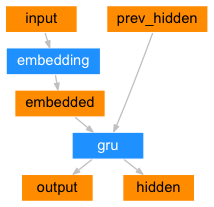

In [86]:
class EncoderRNN(nn.Module):
    def __init__(self, input_dim, emb_dim, hidn_dim):
        super(EncoderRNN, self).__init__()
        self.hidn_dim = hidn_dim
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=0)  # one-hot 사용하면 embedding layer 사용 X, TODO padding_idx
        self.lstm = nn.LSTM(emb_dim, hidn_dim, batch_first=True)  # LSTM
        # TOTO dropout
        
    def forward(self, inputs, prev_hidden, prev_cell):
        """
        inputs: (batch_size, max_seq_len, hidn_dim)
        prev_hidden: (batch_size, hidn_dim, hidn_dim)
        embedded: (batch_size, seq_len, hidn_size)
        output: (batch_size, seq_len, hidn_size)
        hidden: (batch_size, seq_len, hidn_size)
        cell: (batch_size, seq_len, hidn_size)
        """
#         print('input size : %s' % str(inputs.size()))
        embedded = self.embedding(inputs)
#         print('embedding size : %s' % str(embedded.size()))
#         print('prev_hidden size : %s' % str(prev_hidden.size()))
        output, (hidden, cell) = self.lstm(embedded, (prev_hidden, prev_cell))
#         print('output size : %s' % str(output.size()))
#         print('hidden size : %s' % str(hidden.size()))
        return output, hidden, cell

Decoder   
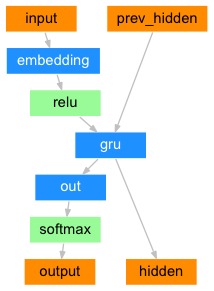

In [87]:
class DecoderRNN(nn.Module):
    def __init__(self, output_dim, emb_dim, hidn_dim):
        super(DecoderRNN, self).__init__()
        self.hidn_dim = hidn_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidn_dim, batch_first=True)
        self.out = nn.Linear(hidn_dim, output_dim)
#         self.softmax = nn.LogSoftmax(dim=0)  # dim은 배치 기준인듯, Softmax와 차이? dim?
    def forward(self, inputs, prev_hidden, prev_cell):
        """
        * use batch_first = True
        inputs: (batch_size, 1)
        embedded: (batch_size, 1, hidn_size)
        output: (batch_size, 1, hidn_size)
        hidden: (batch_size, 1, hidn_size)
        cell: (batch_size, 1, hidn_size)
        """
        inputs = inputs.unsqueeze(1)
#         print('inputs')
#         print(inputs)
#         print('inputs size : %s' % str(inputs.size()))
        embedded = self.embedding(inputs)
#         print('prev_hidden size : %s' % str(prev_hidden.size()))
        output = F.relu(embedded)  # nn.ReLU랑 차이점?
        output, (hidden, cell) = self.lstm(output, (prev_hidden, prev_cell))
#         print('output size : %s' % str(output.size()))
#         output = self.softmax(self.out(output))
#         print('output-lstm size : %s' % str(output.size()))
#         print(output)
        output = self.out(output)
#         print('output size : %s' % str(output.size()))
#         print('hidden size : %s' % str(hidden.size()))
        output = output.squeeze(1)
#         print('output size : %s' % str(output.size()))
#         from IPython import embed; embed()
        return output, hidden, cell

### Attention Decoder 
![image](https://tutorials.pytorch.kr/_images/attention-decoder-network.png)

In [88]:
# # DecoderRNN 대신 사용
# # Attention layer가 추가된 Decoder layer를 생성
# class AttnDecoderRNN(nn.Module):
#     def __init__(self, seq_len, hidden_size, output_size, dropout=0.5):
#         super(AttnDecoderRNN, self).__init__()
#         self.hidden_size = hidden_size
#         self.output_size = output_size
#         self.dropout = nn.Dropout(dropout)
#         self.seq_len = seq_len
        
# #         self.embedding = nn.Embedding(self.output_size, self.hidden_size)  # one-hot 사용하면 embedding layer 사용 X
#         self.attn = nn.Linear(self.hidden_size * 2, self.seq_len)
#         self.attn_comb = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
#         self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
#         self.out = nn.Linear(hidden_size, output_size)
#         self.softmax = nn.LogSoftmax(dim=1)
        
#     def forward(self, inputs, hidden, encoder_outputs):
# #         embedded = self.embedding(inputs)  # Autoregressive -> .view(1, 1, -1) (1, 1, 남는 차원)으로 reshape
        
#         # 1st attention layer
#         # 두 layer를 어떻게 linear layer의 input으로 넣을건지 -> concat
#         attn_weight = self.softmax(self.attn(torch.cat(inputs, hidden, 1)))
#         # encoder_outputs에 attention 적용
#         # bmm: batch matrix multiplication
#         attn_applied = torch.bmm(attn_weight, encoder_outputs, 1)
#         attn_combined = self.attn_comb(torch.cat(embedded, attn_applied, 1))
        
#         output = F.ReLU(attn_combined)  # nn.ReLU랑 차이점?
#         output, hidden = self.gru(output, hidden)
#         output = self.softmax(self.out(output))
        
#         return output, hidden, attn_weight
        
#     def init_hidden(self):
#         return torch.zeros(1, self.seq_len, self.hidden_size, device=device)  # device?

### Load Data

In [89]:
# # input data
# src_padded = nn.utils.rnn.pad_sequence(src_tensors, batch_first=True, padding_value=0)  # padding_value = (max_len 또는) SOS 뒤로 밀기
# tar_padded = nn.utils.rnn.pad_sequence(tar_tensors, batch_first=True, padding_value=0)  # padding_value = (max_len 또는) SOS 뒤로 밀기

In [90]:
# real data
src_tensors = []
tar_tensors = []

input_dic, output_dic, pairs = prepare_data(prod_seq_col, prod_seq_col, share_dic=True)

for pair in pairs:
    (src_tensor, tar_tensor) = tensors_from_pair(input_dic_1, output_dic_1, pair, device)
    src_tensors.append(src_tensor)
    tar_tensors.append(tar_tensor)

src_padded = nn.utils.rnn.pad_sequence(src_tensors, batch_first=True, padding_value=0)  # padding_value = (max_len 또는) SOS 뒤로 밀기
tar_padded = nn.utils.rnn.pad_sequence(tar_tensors, batch_first=True, padding_value=0)  # padding_value = (max_len 또는) SOS 뒤로 밀기

Preparing data...


In [91]:
# # fake data
# src_tensors = []
# tar_tensors = []
# # 샘플 데이터
# input_dic_1, output_dic_1, pairs = prepare_data(fake_data, fake_data)

# for pair in pairs:
#     (src_tensor, tar_tensor) = tensors_from_pair(input_dic_1, output_dic_1, pair, device)
#     src_tensors.append(src_tensor)
#     tar_tensors.append(tar_tensor)

# src_padded = nn.utils.rnn.pad_sequence(src_tensors, batch_first=True, padding_value=0)  # padding_value = (max_len 또는) SOS 뒤로 밀기
# tar_padded = nn.utils.rnn.pad_sequence(tar_tensors, batch_first=True, padding_value=0)  # padding_value = (max_len 또는) SOS 뒤로 밀기

In [92]:
src_padded[0]

tensor([1, 5, 5, 6, 5, 5, 4, 3, 5, 6, 3, 5, 6, 4, 4, 4, 6, 5, 4, 5, 3, 5, 5, 3,
        3, 3, 6, 6, 5, 4, 6, 3, 5, 3, 3, 6, 4, 3, 5, 3, 5, 5, 6, 4, 3, 3, 4, 5,
        3, 5, 5, 5, 3, 4, 5, 5, 3, 6, 3, 5, 4, 3, 3, 3, 5, 6, 3, 3, 3, 6, 3, 6,
        4, 5, 4, 5, 5, 5, 5, 6, 6, 6, 3, 3, 3, 3, 3, 3, 3, 5, 4, 5, 5, 3, 3, 3,
        6, 3, 5, 6, 5, 5, 3, 5, 5, 4, 5, 5, 3, 4, 5, 6, 4, 5, 6, 6, 5, 5, 5, 5,
        6, 3, 3, 6, 5, 5, 5, 3, 5, 3, 3, 4, 6, 4, 5, 4, 3, 3, 3, 5, 5, 5, 4, 5,
        6, 5, 5, 6, 3, 4, 5, 3, 5, 6, 5, 5, 5, 5, 4, 6, 3, 3, 6, 3, 3, 6, 3, 4,
        4, 5, 3, 3, 5, 6, 3, 5, 5, 6, 3, 6, 4, 3, 3, 3, 3, 5, 4, 3, 6, 3, 4, 4,
        3, 3, 3, 3, 5, 4, 3, 2])

In [93]:
tar_padded

tensor([[1, 3, 3,  ..., 6, 5, 2],
        [1, 3, 4,  ..., 0, 0, 0],
        [1, 5, 3,  ..., 0, 0, 0],
        ...,
        [1, 6, 3,  ..., 0, 0, 0],
        [1, 3, 5,  ..., 0, 0, 0],
        [1, 5, 3,  ..., 0, 0, 0]])

In [94]:
# Encoder / Decoder Test
# hyperparameter
batch_size = src_padded.size(0)
max_seq_len = src_padded.size(1)
emb_dim = 24
vocab_size = 7
hidn_dim = 64

In [95]:
# layer
encoder = EncoderRNN(vocab_size, emb_dim, hidn_dim)
decoder = DecoderRNN(vocab_size, emb_dim, hidn_dim)

In [96]:
encoder.parameters

<bound method Module.parameters of EncoderRNN(
  (embedding): Embedding(7, 24, padding_idx=0)
  (lstm): LSTM(24, 64, batch_first=True)
)>

In [97]:
decoder.parameters

<bound method Module.parameters of DecoderRNN(
  (embedding): Embedding(7, 24)
  (lstm): LSTM(24, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=7, bias=True)
)>

## Training

전체 학습 과정은 다음과 같습니다:

- 타이머 시작
- optimizers와 criterion 초기화
- 학습 쌍의 세트 생성
- 도식화를 위한 빈 손실 배열 시작

In [108]:
# training parameters
epochs = 5000

In [ ]:
# train with iteration
train_iters(encoder, decoder, src_padded, tar_padded, epochs, batch_size, device, \
            teacher_forcing_ratio=0.2, print_every=100, plot_every=10, learning_rate=1e-5)
# learning rate가 커서 발산하면 loss가 감소하지 않고 유지될 수 있다.

In [ ]:
sentences = ['AAAAAAAA'*5, 
             'ATATATAA'*5,
             'ATGCATGC'*5,
             'ATGCATGC'*10]
# batch inference 는 구현 안함
batch_size_eval = 1
# batch_size_eval = len(sentences)
decoded_words = []

for sent in sentences:
    (src_tensor, tar_tensor) = tensors_from_pair(input_dic, input_dic, (sent, sent), device)
    decoded_word = evaluate(encoder, decoder, src_tensor, tar_tensor, batch_size_eval, input_dic, device)
    result_word = ''
    for base in decoded_word:
        result_word += base
    decoded_words.append(result_word)

In [ ]:
decoded_words